# Анализ результатов А/В теста

**Цель исследования** — оценить корректность проведения А/В-теста, изучить платежную воронку, проанализировать результаты А/В-теста. 

**Техническое задание:**
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
**Ход исследования:**
1. Изучение общей информации. Предобработка данных:
    - проверить типы данных
    - проверить наличие пропусков и дубликатов
2. Изучение и проверка данных
    - проверить данные на соответствие ТЗ
    - проверка распределяющей системы тестирования
3. Исследовательский анализ данных
    - оценить количество событий на группы эксперимента
    - оценить частоту событий
    - построить воронку событий
    - проверка распределяющей системы тестирования
4. Изучение результаты АВ-эксперимента
    - проверка статистических гипотез
5. Результаты исследования

## Обзор и предобработка данных

Изучим данные и выполним их предобработку: при необходимости приведем наименования столбцов к единому стилю, проверим соответствие типов данных сохранённым в них значениям, проверим наличие в данных пропусков и дубликатов.

### Обзор данных

Импортируем библиотеки необходимые нам в решении задач исследования.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as st
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import math as mth


# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
#улучшим четкость изображения графиков
%config InlineBackend.figure_format = 'retina'

In [3]:
import plotly.io as pio
pio.renderers.default = 'png'
svg_renderer = pio.renderers['png']
svg_renderer.scale = 1.2

Ознакомимся с данными:

In [4]:
final_ab_participants = pd.read_csv('final_ab_participants.csv')

print('Первые 5 строк датасета:')
display(final_ab_participants.head())
print('Информация о хранящихся в нем данных:')
final_ab_participants.info()

Первые 5 строк датасета:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Информация о хранящихся в нем данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Согласно документации к данным `final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [5]:
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv')

print('Первые 5 строк датасета:')
display(ab_project_marketing_events.head())
print('Информация о хранящихся в нем данных:')
ab_project_marketing_events.info()

Первые 5 строк датасета:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Информация о хранящихся в нем данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [6]:
final_ab_new_users = pd.read_csv('final_ab_new_users.csv')

print('Первые 5 строк датасета:')
display(final_ab_new_users.head())
print('Информация о хранящихся в нем данных:')
final_ab_new_users.info()

Первые 5 строк датасета:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Информация о хранящихся в нем данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [7]:
final_ab_events = pd.read_csv('final_ab_events.csv')

print('Первые 5 строк датасета:')
display(final_ab_events.head())
print('Информация о хранящихся в нем данных:')
final_ab_events.info()

Первые 5 строк датасета:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Информация о хранящихся в нем данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

По первому взгляду на датасет можно сделать следующие **выводы:**
* типы данных не соответствуют сохраненным в них значениям: столбцы с датами определены как тип данных `object`
* наименования столбцов удобны для дальнейшей работы и не требуют предобработки.

### Предобработка данных

Преобразуем данные о времени, а также добавим столбец с датой, он пригодится нам для дальнейшего исследования:

In [8]:
#преобразование данных о времени
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
#добавляем новый столбец с датой
final_ab_events['date'] = pd.to_datetime(final_ab_events['event_dt']).dt.date
#добавляем новый столбец с датой и часом
#final_ab_events['hour'] = final_ab_events['event_dt'].dt.strftime('%Y-%m-%d %H')

#проверка типов данных
display(ab_project_marketing_events.info())
display(final_ab_new_users.info())
display(final_ab_events.info())
#проверка данных
display(ab_project_marketing_events.head())
display(final_ab_new_users.head())
display(final_ab_events.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   date        440317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.8+ MB


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


In [9]:
#проверим датасеты на наличие явных дубликатов
print(f'Количество явных дубликатов: {final_ab_participants.duplicated().sum()}')
print(f'Количество явных дубликатов: {ab_project_marketing_events.duplicated().sum()}')
print(f'Количество явных дубликатов: {final_ab_new_users.duplicated().sum()}')
print(f'Количество явных дубликатов: {final_ab_events.duplicated().sum()}')

#проверим датасеты на наличие пропущенных значений
#вспомогательная переменная, перенос строки
nl = '\n'
print(f'Количество пропущенных значений:{nl}{final_ab_participants.isna().sum()}')
print(f'Количество пропущенных значений:{nl}{ab_project_marketing_events.isna().sum()}')
print(f'Количество пропущенных значений:{nl}{final_ab_new_users.isna().sum()}')
print(f'Количество пропущенных значений:{nl}{final_ab_events.isna().sum()}')

Количество явных дубликатов: 0
Количество явных дубликатов: 0
Количество явных дубликатов: 0
Количество явных дубликатов: 0
Количество пропущенных значений:
user_id    0
group      0
ab_test    0
dtype: int64
Количество пропущенных значений:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Количество пропущенных значений:
user_id       0
first_date    0
region        0
device        0
dtype: int64
Количество пропущенных значений:
user_id            0
event_dt           0
event_name         0
details       377577
date               0
dtype: int64


Явных дубликатов нет. Есть пропущенные значения в таблице `final_ab_events`, содержащей информацию о действиях пользователей, в столбце `details`,содержащим информацию о доп. информации о событии (стоимость покупки если событие "покупка"). Оставим эти пропуски т.к. по событиям отличным от "покупки" нет доп.информации.

## Изучение и проверка данных

Оценим корректность проведения теста, для этого:
- проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.

### Соответствие данных требованиям ТЗ

Согласно ТЗ для теста должны отбираться 15% новых пользователей из региона EU, ожидаемое количество участников 6000. Дата запуска: 2020-12-07, дата остановки набора новых пользователей: 2020-12-21. Проверим так ли это:

In [10]:
#объединим таблицу, содержащую данные участников теста, и таблицу, содержащую данные о новых пользователях
check_data = final_ab_participants.merge(final_ab_new_users, on='user_id', how='right')

#проверим временные рамки
print('Минимальная дата регистрации участников теста:', 
      check_data.query('ab_test == "recommender_system_test"')['first_date'].min())
print('Максимальная дата регистрации участников теста:', 
      check_data.query('ab_test == "recommender_system_test"')['first_date'].max())

#участники теста из региона EU
print('Количество пользователей, отобранных в АВ-тест:', \
      check_data.query('ab_test == "recommender_system_test" & region == "EU"')['user_id'].nunique())

#найдем долю участников нужного теста из региона EU от новых пользователей 
#из региона EU зарегистрировавшихся в даты набора участников в тест 
print('Доля пользователей из региона EU, отобранных в АВ-тест(%):', 
        round((check_data.query(
            'ab_test == "recommender_system_test" & region == "EU"'
        )['user_id'].nunique()) / final_ab_new_users.query(
            'region == "EU" & first_date >= "2020-12-07" & first_date <= "2020-12-21"'
        )['user_id'].nunique() * 100, 2))

#таблица содержащая пользователей согласно ТЗ
check_data = check_data.query(
            'ab_test == "recommender_system_test" & region == "EU" \
            & first_date >= "2020-12-07" & first_date <= "2020-12-21"')

Минимальная дата регистрации участников теста: 2020-12-07 00:00:00
Максимальная дата регистрации участников теста: 2020-12-21 00:00:00
Количество пользователей, отобранных в АВ-тест: 6351
Доля пользователей из региона EU, отобранных в АВ-тест(%): 15.0


**Вывод:** значения похожи на ожидаемые по ТЗ: в тест были отобраны 6351 новых пользователей из региона EU, зарегистрировавшихся в даты регистрации в тест, это составляет 15% от общего количества новых пользователей из региона EU.

Проверим распределяющую систему теста на технические ошибки:

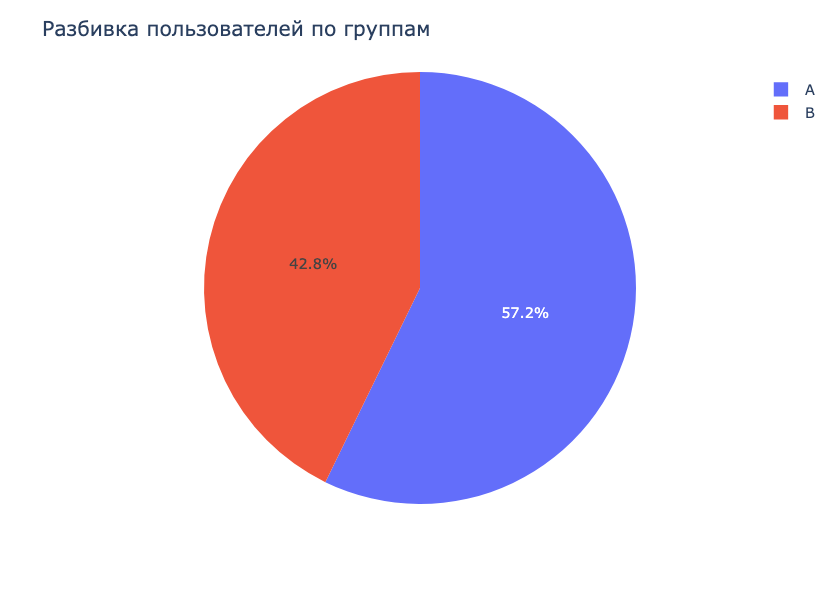

,group,total_count
0,A,3634
1,B,2717


In [11]:
#сгруппируем данные по группам эксперимента и посчитаем количество уникальных пользователей
visitors_per_var = check_data.groupby(
    'group')[['user_id']].agg('nunique')
#переименуем столбец
visitors_per_var.columns = ['total_count']
visitors_per_var = visitors_per_var.reset_index()

#круговая диаграмма по собранным данным
fig = px.pie(visitors_per_var, values='total_count', names='group')

#оформление графика
fig.update_layout(title='Разбивка пользователей по группам')
fig.show()

display(visitors_per_var)

Отмечается перекос отобранных участников эксперимента в контрольную группу А: 57% участников зарегистрированы в группе А, 43% участников группы В. Из чего следует вывод что **распределяющая система работает некорректно.**

### Проверка аудитории теста

Проверим есть ли пересечение с конкурирующим тестом.

In [12]:
#проверим данные на количество АВ-тестов
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Так как исследуемые нами данные содержат информацию о 2-х конкурирующих АВ-тестах нам необходимо произвести чистку информации. Пользователи могут распределяться следующим образом:
1) участвующие только в тесте `recommender_system_test`
2) участвующие только в конкурирующем тесте
3) участвующие в обоих тестах одновременно, такие пользователи в следующую очередь деляться на:
- участники А-группы в обоих тестах (таких пользователей удалять не будем т.к. на них не было влияния изменений)
- участники А-гр конкурирующего теста, В-группы теста `recommender_system_test` (таких пользователей удалять не будем т.к. на них не было влияния изменений конкурирующего теста)
- участники В-группы в обоих тестах (удалим таких пользователей, невозможно определить изменения какого теста на них повлияли)
- участники В-гр конкурирующего теста, А-группы теста `recommender_system_test` (удалим таких пользователей, т.к. возможно на них повлияли изменения конкурирующего теста)

Нас интересует тест `recommender_system_test` проверим нет ли в нем участников попавших одновременно и в А и в В группы:

In [13]:
#находим количество уникальных групп для каждого пользователя 
#фильтруем пользователей с более чем 1 группой
bug_visitors = final_ab_participants.query('ab_test == "recommender_system_test"').pivot_table(
    index = 'user_id', 
    values = 'group', 
    aggfunc = 'nunique').query('group > 1').reset_index()


print(f'Количество пользователей с ошибками: {bug_visitors.shape[0]}')

Количество пользователей с ошибками: 0


Таких участников нет, проверим нет ли среди участников интересующего нас АВ-теста участников двух АВ-тестов одновременно:

In [14]:
#находим количество уникальных АВ-тестов для каждого пользователя 
#фильтруем пользователей с более чем 1 тестом
bug_visitors_2test = final_ab_participants.pivot_table(
    index = 'user_id', 
    values = 'ab_test', 
    aggfunc = 'nunique').query('ab_test > 1').reset_index()


print(f'Количество пользователей, участвующих в 2-х АВ-тестах: {bug_visitors_2test.shape[0]}')
print('Доля таких пользователей (%):', 
        round(bug_visitors_2test.shape[0] / final_ab_participants.query(
            'ab_test == "recommender_system_test"'
        )['user_id'].nunique() * 100, 2))

#выводим на экран данные пользователей, участвующих в 2-х АВ-тестах
bug_2test = bug_visitors_2test['user_id'].tolist()
final_ab_participants.query('user_id in @bug_2test').sort_values(by='user_id').head(10)

Количество пользователей, участвующих в 2-х АВ-тестах: 1602
Доля таких пользователей (%): 23.91


,user_id,group,ab_test
17892,001064FEAAB631A1,B,interface_eu_test
235,001064FEAAB631A1,B,recommender_system_test
16961,00341D8401F0F665,A,interface_eu_test
2137,00341D8401F0F665,A,recommender_system_test
8143,003B6786B4FF5B03,A,interface_eu_test
3156,003B6786B4FF5B03,A,recommender_system_test
4768,0082295A41A867B5,A,recommender_system_test
14161,0082295A41A867B5,B,interface_eu_test
15562,00E68F103C66C1F7,B,interface_eu_test
4074,00E68F103C66C1F7,A,recommender_system_test


Удалим участников В-группы конкурирующего теста т.к. тестируемые изменения в конкурирующем тесте могли повлиять на результат интересующего нас теста:

In [15]:
#список идентификаторов пользователей, участвующих в конкурирующем тесте в В-группе
bug_Bgroup = final_ab_participants.query(
    'user_id in @bug_2test & (group == "B" & ab_test == "interface_eu_test")'
)['user_id'].tolist()

print(f'Количество пользователей, участвующих в группе B конкурирующего теста: {len(bug_Bgroup)}')
print('Доля таких пользователей (%):', 
        round(len(bug_Bgroup) / final_ab_participants.query(
            'ab_test == "recommender_system_test"'
        )['user_id'].nunique() * 100, 2))

#удалим таких пользователей
final_ab_participants = final_ab_participants.query('user_id not in @bug_Bgroup')

Количество пользователей, участвующих в группе B конкурирующего теста: 783
Доля таких пользователей (%): 11.68


Мы избавились от некорректных участников, финальная таблица содержащая только участников интересующего нас теста:

In [16]:
#очищенные данные только по интересующему нас тесту
final_ab_participants = final_ab_participants.query('ab_test == "recommender_system_test"')
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Оставим в ранее созданной таблице `check_data` участников теста после очистки от пересечений с конкурирующем тестом.

In [17]:
#идентификаторы участников теста
users = final_ab_participants['user_id'].unique().tolist()

#таблица после очистки от пользователей конкурирующего теста
data = check_data.query('user_id in @users')

Оставим в таблице, содержащей информацию о событиях совершаемых пользователями, информацию только об интересующих нас пользователях (участников теста):

In [18]:
#очистка таблицы
final_ab_events = final_ab_events.query('user_id in @users')
#временные рамки
print('Минимальная дата события теста:', final_ab_events['event_dt'].min())
print('Минимальная дата события теста:', final_ab_events['event_dt'].max())

Минимальная дата события теста: 2020-12-07 00:05:57
Минимальная дата события теста: 2020-12-30 12:42:57


Дата остановки теста по ТЗ: 2021-01-04, а последние данные о событиях от 2020-12-30, возможно ошибка сбора или выгрузки информации.

Посмотрим как пользователи  после их очистки распределяются между группами эксперимента:

Количество пользователей, участвующих в АВ-тесте: 5568
Доля исключенных пользователей(%): 12.33


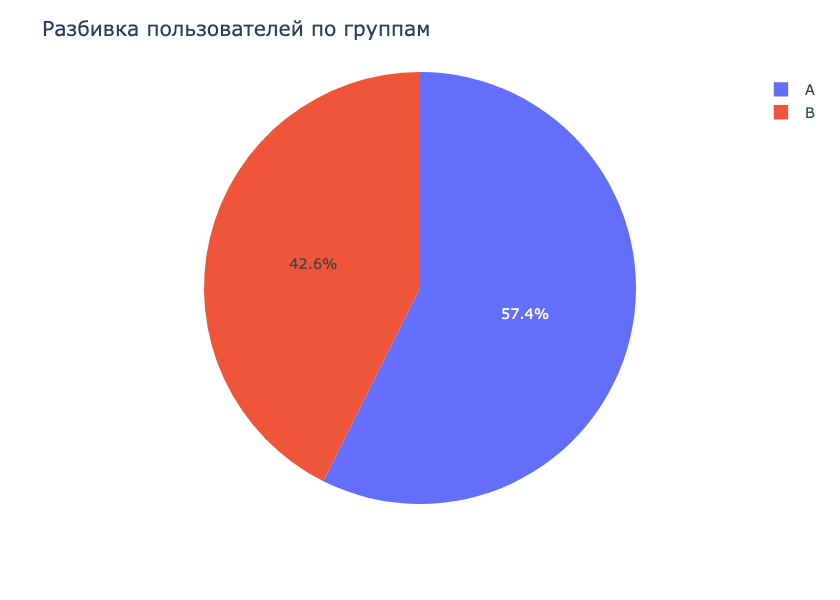

,group,total_count
0,A,3195
1,B,2373


In [19]:
print('Количество пользователей, участвующих в АВ-тесте:',
      data['user_id'].nunique())
print('Доля исключенных пользователей(%):', 
        round(( 1 - data['user_id'].nunique()/check_data['user_id'].nunique()) * 100, 2))

#сгруппируем данные по группам эксперимента и посчитаем количество уникальных пользователей
visitors_per_var = data.groupby(
    'group')[['user_id']].agg('nunique')
#переименуем столбец
visitors_per_var.columns = ['total_count']
visitors_per_var = visitors_per_var.reset_index()

#круговая диаграмма по собранным данным
fig = px.pie(visitors_per_var, values='total_count', names='group')

#оформление графика
fig.update_layout(title='Разбивка пользователей по группам')
fig.show()

display(visitors_per_var)

Участники эксперимента делятся между группами АВ в соотношении 57/43%, в группе А участников больше более чем на 800 человек чем в группе В. Далее в исследование проверим как события распределяются между группами.

### Проверка времени проведения теста

Посмотрим на календарь маркетинговых событий на 2020 год и проверим нет ли пересечения между тестом и каким-либо маркетинговым событием:

In [20]:
ab_project_marketing_events.query('start_dt >= "2020-12-07" | finish_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В исследуемом регионе EU проводилась маркетинговая активность `Christmas&New Year Promo` с 25 декабря до 03 января, эта активность могла повлиять на поведение пользователей.

Посмотрим на распределение событий по дням и оценим влияние маркетинговой акции на группы теста:

Для начала сформируем итоговую таблицу для анализа АВ-тестирования: она должна содержать таблицу событий и данные о том к какой группе относится пользователей совершивший это событие.

In [21]:
#итоговая таблица
final_ab_events = final_ab_events.merge(data, on='user_id')

print('Количество событий пересекаемых с маркетинговой акцией:', \
      final_ab_events.query("event_dt >= '2020-12-25'")['event_dt'].count())
print('Доля таких событий (%):', 
        round(final_ab_events.query(
            "event_dt >= '2020-12-25'")['event_dt'].count()/ final_ab_events['event_dt'].count() * 100, 2))

Количество событий пересекаемых с маркетинговой акцией: 2779
Доля таких событий (%): 13.51


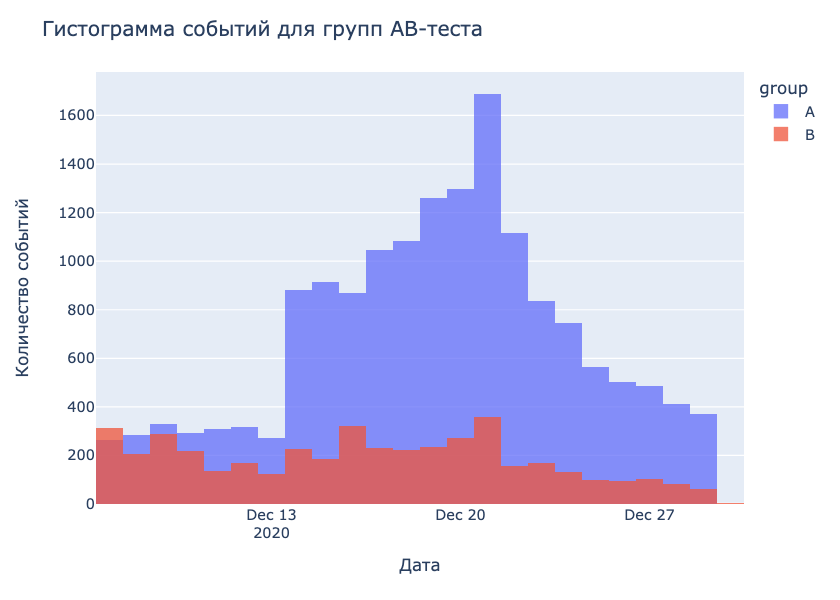

In [22]:
fig = px.histogram(final_ab_events, x='date', color='group')
#оформление графика
fig.update_layout(title='Гистограмма событий для групп АВ-теста',
                   xaxis_title='Дата',
                   yaxis_title='Количество событий',
                   barmode='overlay')
fig.update_traces(opacity=0.75)

fig.show()

**Вывод:** как видно по графику, маркетинговая акция не вызвала резких изменений количества событий, ежедневное количество событий для групп эксперимента распределяются схоже во временных рамках маркетинговой активности (после 25 декабря включительно). В связи с этим не будем удалять информацию об этих событиях, т.к. она составляет около 13.5% от информации обо всех собранных событиях. 

Также стоит отметить что 30 декабря и позже нет данных о событиях, возможно это связано с ошибками сбора или выгрузки данных. 

### Учет 14-ти дневного лайфтайма

Согласно ТЗ ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%, поэтому избавимся от событий дата которых превышает 14 дней с дня регистрации:

In [23]:
#посчитаем разницу между датой события и датой регистрации пользователя
final_ab_events['first_date'] = pd.to_datetime(final_ab_events['first_date']).dt.date
final_ab_events['days'] = (final_ab_events['date'] - final_ab_events['first_date']).dt.days

print('Количество событий старше 14 дней:', final_ab_events.query('days > 14')['event_dt'].count())
print('Доля таких событий (%):', 
        round(final_ab_events.query('days > 14')['event_dt'].count() / final_ab_events['event_dt'].count() * 100, 2))

#удаляем события старше 14 дней
final_ab_events = final_ab_events.query('days <= 14')

Количество событий старше 14 дней: 530
Доля таких событий (%): 2.58


**Вывод:** Доля событий старше 14 дней составляет чуть более 2,5%, удалим данные об этих событиях, так как мы не потеряем большую долю пользователей и проведем исследования согласно ТЗ.

## Исследовательский анализ данных

### Распределение количества событий на пользователя

Рассмотрим как распределяется количество событий на пользователя для каждой группы:

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,15851.0,5.658570,2.408793,1.0,4.0,5.0,7.0,14.0
B,4183.0,4.855367,2.477421,1.0,3.0,4.0,6.0,16.0


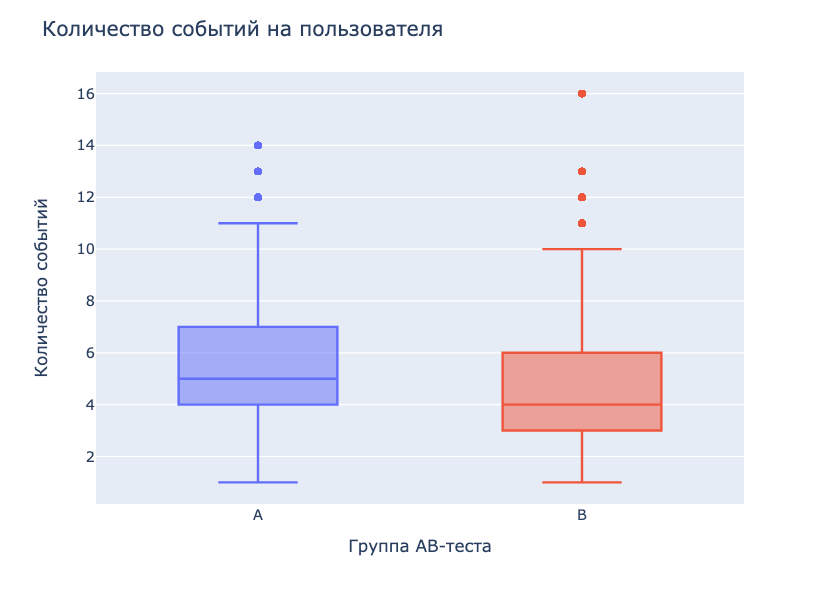

In [24]:
#готовим данные для графика
#посчитаем количество событий для каждого пользователя
avg_events_by_group = final_ab_events.merge(final_ab_events.groupby('user_id').agg(
total=('event_dt', 'nunique')).reset_index(), how='left')

#статистические данные о количествe событий для каждой группы
display(
    avg_events_by_group.groupby(['group'])['total'].describe().sort_values(by='50%', ascending=False)
)

#диаграмма размаха по количеству событий на пользователя
fig = px.box(avg_events_by_group, x='group', y='total', color='group')

#оформление графика
fig.update_layout(title='Количество событий на пользователя',
                   xaxis_title='Группа АВ-теста',
                   yaxis_title='Количество событий',
                   showlegend=False)

fig.show()

**Вывод:** среднее значение количества событий на пользователя для группы А - 5.65 события, для группы В - 4.85 события. Медианные значения 5 событий для пользователя из группы А, 4 события для пользователя из группы В. В целом количество событий распределяются в группах однообразно, без явных отличий, несмотря на существенное различие в количестве участников групп эксперимента.

Также рассмотрим все ли пользователи в группах совершали события после регистрации в тесте:

In [25]:
#найдем количество уникальных пользователей совершивших событие для каждой группы
users_by_group = data.groupby(['group']).agg(total_users=(
    'user_id', 'nunique'
)).reset_index().merge(final_ab_events.groupby('group').agg(
    events_users=('user_id', 'nunique')).reset_index(), how='left')


#ищем долю пользователей совершивших события после регистрации в тесте
users_by_group['share'] = (
    users_by_group['events_users'] / users_by_group['total_users'] * 100
).round(1)
users_by_group

,group,total_users,events_users,share
0,A,3195,2279,71.3
1,B,2373,771,32.5


**Вывод:** более 71% зарегистрировавшихся в тесте пользователей А-группы совершили хотя бы 1 событие, существенно отличается картина у пользователей В-группы всего около 32% зарегистрировавшихся в тесте пользователей совершили хотя бы 1 событие.

Возможно дело в некорректном отображении сайта на различных девайсах, проверим как распределяющая система разбивает пользователей по группам в зависимости от девайсов:

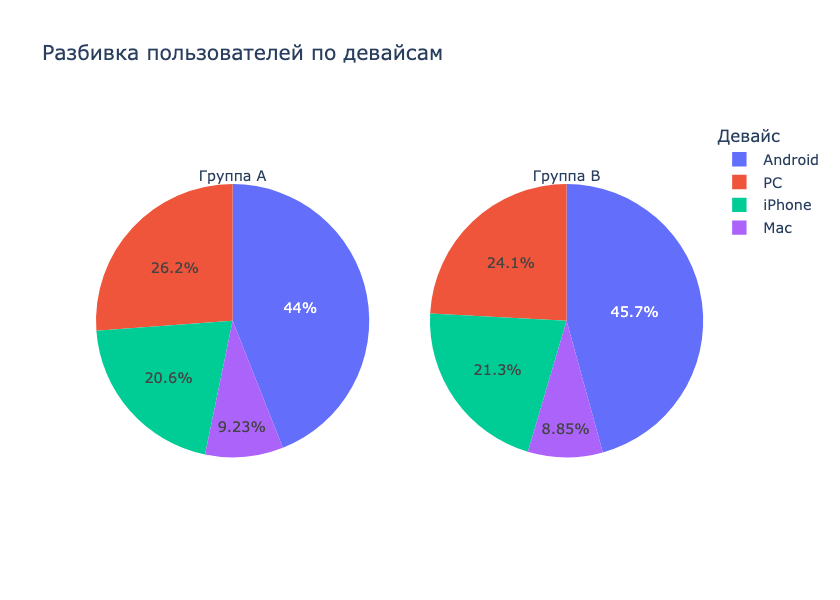

In [26]:
data_by_device = data.groupby(['group', 'device'])['user_id'].nunique()
#переименуем столбец
data_by_device.columns = ['total_count']
data_by_device = data_by_device.reset_index()

#круговая диаграмма по собранным данным
labels = data_by_device['device'].unique().tolist()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, 
                     values=data_by_device.query('group=="A"')['user_id'], 
                     title='Группа А'),
              1, 1)
fig.add_trace(go.Pie(labels=labels, 
                     values=data_by_device.query('group=="B"')['user_id'], 
                     title='Группа В'),
              1, 2)




#оформление графика
fig.update_layout(title='Разбивка пользователей по девайсам',
                  legend_title = 'Девайс')
fig.show()

**Вывод:** как видно распределяющая система разбивает пользователей по группам в зависимости от девайсов пропорционально и однообразно, то есть проблема авторизации на сайте после регистрации не связано с некорректным отображением интерфейса (к примеру) на каком либо девайсе.

### Частота событий

Рассмотрим как число событий распределено по дням для групп АВ-теста:

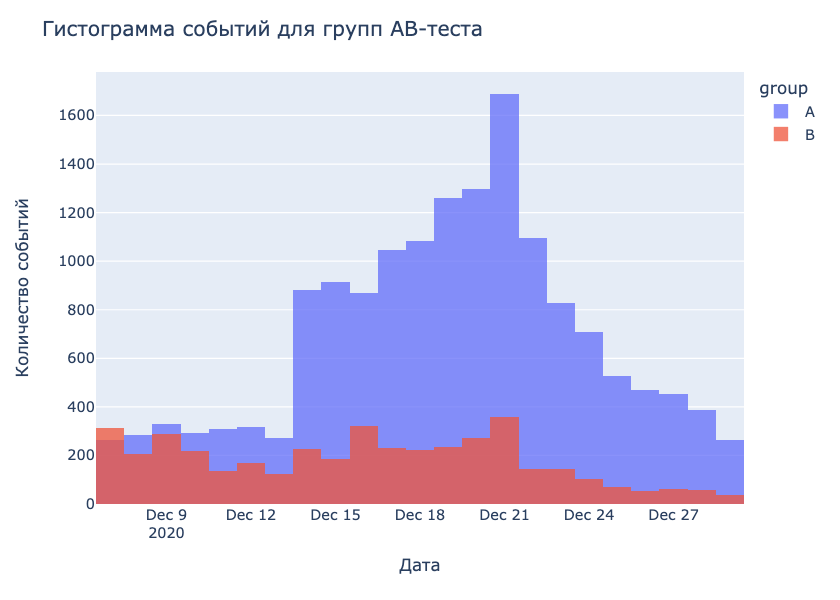

In [27]:
fig = px.histogram(final_ab_events, x='date', color='group')
#оформление графика
fig.update_layout(title='Гистограмма событий для групп АВ-теста',
                   xaxis_title='Дата',
                   yaxis_title='Количество событий',
                   barmode='overlay')
fig.update_traces(opacity=0.75)

fig.show()

**Вывод:** количество событий в день для группы А существенно больше чем у группы В и распределяются они менее равномерно, отмечается резкий скачок 14 декабря, тенденция к росту, и снова резкий скачок 21 декабря, после чего наблюдается спад активности.

### Изучение продуктовой воронки

In [28]:
print('Исследуемые события:', final_ab_events['event_name'].unique())

Исследуемые события: ['purchase' 'product_cart' 'login' 'product_page']


Дадим определения событий:
* `login` - авторизация пользователя (зашел на сайт)
* `product_page` - просмотр каталога продукции
* `purchase` - покупка
* `product_cart`  - просмотр корзины

Соберем данные необходимые нам для дальнейшего исследования, для каждой группы эксперимента определим количество пользователей по событиям users_count и процент пользователей совершивших целевое действие (по событиям) от начального шага воронки (авторизация пользователей) - cr.

In [29]:
#собираем данные
df = pd.DataFrame()
groups = final_ab_events['group'].unique()

for g in groups:
    df_by_group = final_ab_events.query('group == @g').groupby('event_name').agg({
        'group' : 'max',
        'user_id' : 'nunique'
    }).sort_values(by='user_id', ascending=False).reset_index()
    df_by_group .columns = ['event_name', 'group', 'users_count']
    df_by_group ['cr'] = round(
        df_by_group['users_count'] / final_ab_events.query('group == @g')['user_id'].nunique() * 100, 2)
    new_index = {2: 3, 3: 2}
    df_by_group  = df_by_group .rename(new_index).sort_index()
    df = pd.concat([df, df_by_group ])

df

,event_name,group,users_count,cr
0,login,A,2279,100.00
1,product_page,A,1476,64.77
2,product_cart,A,686,30.10
3,purchase,A,734,32.21
0,login,B,770,99.87
1,product_page,B,429,55.64
2,product_cart,B,214,27.76
3,purchase,B,219,28.40


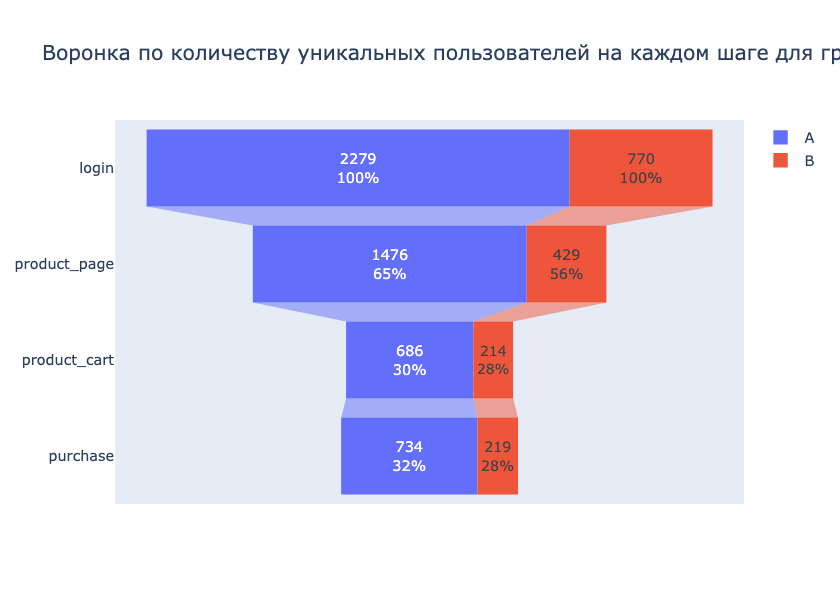

In [30]:
#напишем цикл который будет строить продуктовую воронку для каждой группы эксперимента

fig = go.Figure()

for g in groups:
    #строим воронку по количеству уникальных пользователей на каждом шаге
    fig.add_trace(go.Funnel(
    name = g,
    orientation = 'h',
    y = df.query('group == @g')['event_name'],
    x = df.query('group == @g')['users_count'],
    textposition = 'inside',
    textinfo = 'value+percent initial'))

fig.update_layout(title='Воронка по количеству уникальных пользователей на каждом шаге для групп АВ-теста')
fig.show()

In [31]:
#таблица которая хранит количество пользователей зарегистрировавшихся в тесте
#и количество пользователей совершивших хотя бы 1 событие для каждой группы эксперимента
users_by_group

,group,total_users,events_users,share
0,A,3195,2279,71.3
1,B,2373,771,32.5


**Выводы**: Можно предположить что покупка товара возможна без открытия страницы корзины пользователя (покупка в 1 клик), т.к. в обеих группах количество события "покупка" превышает количество событий "просмотр корзины".


Так как количество событий и пользователей группы А более чем в 2 раза превышает количество событий и пользователей группы В будем опираться на конверсию в каждый шаг от начального шага воронки:
* Событие `product_page` - просмотр каталога продукции: 65% пользователей группы А, 56% - группы В
* Далее следуют `product_cart` - просмотр корзины: 30% от посетителей сайта группа А, 28% от посетителей сайта группа Б, `purchase` - покупка: 32% группа А, 28% группа В.

По продуктовой воронке видно, что показатели тестовой группы не оправдывают ожиданий эксперимента (ожидалось: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%), наоборот тестовая группа показывает ухудшение каждой метрики относительно контрольной группы.

### Результаты исследовательского анализа данных

В ходе проверки аудитории теста были обнаружены следующие особенности данных:
- пользователи пересекаются с конкурирующим тестом, в связи с этим были исключены данные пользователей участвовавших в конкурирующем тесте в группе В. Потери данных составили: более 12% от всех отобранных в тест пользователей.
- участники распределяются между группами эксперимента неравномерно: в пропорциях 60% группа А, 40% группа В. Необходима проверка распределяющей системы. 
- отсутствуют данные о событиях после 30 декабря вплоть до даты остановки теста 4 января. Возможно ошибка сбора или выгрузки данных.
- период проведения теста пересекается с маркетинговой акцией, данные с 25 декабря по 30 декабря включительно исключены не были, т.к. не обнаружено влияние на количество событий по группам эксперимента.<br>
<br>
В ходе EDA были обнаружены следующие особенности данных:
- участники группы А совершают в среднем больше на 1 событие на пользователя чем участники группы В (5 событий на пользователя группы А, 4 события на пользователя группы В).
- согласно продуктовой воронке тестовая группа показывает ухудшение метрик по сравнению с контрольной группой.

## Изучение результатов AB-эксперимента

In [32]:
#подготовим удобные таблицы для проведения теста
#вспомогательная таблица
users_count = {
    'A': data[data['group']=="A"]['user_id'].nunique(),
    'B': data[data['group']=="B"]['user_id'].nunique()}
#выделим события
events = df[df['event_name'] != 'login']['event_name'].unique().tolist()
#выделим группы
groups = final_ab_events['group'].unique().tolist()

#соберем данные для статистической проверки 
test_group = {}

for group in groups:
    test_group[group] =[]
    
    for event in events:
        
        test_group[group].append(
            final_ab_events[
                (final_ab_events['group'] == group) & (final_ab_events['event_name'] == event)
            ]['user_id'].nunique()
        )
test_group = pd.DataFrame(test_group)
test_group['event_name'] = events

display(users_count)
test_group

{'A': 3195, 'B': 2373}

,A,B,event_name
0,1476,429,product_page
1,686,214,product_cart
2,734,219,purchase


### Проверка статистических гипотез

Мы располагаем данными о контрольной группе и тестовой группе эксперимента А и В. Проверим, находят ли статистические критерии разницу между этими выборками. Для этого проведем тест с использованием z-критерия: проверим гипотезу о равенстве долей двух совокупностей.

Сформулируем гипотезы:

`Нулевая: доли пользователей совершивших событие в группах равны` 

`Альтернативная: есть различия в долях групп`

In [33]:
#создадим универсальную функцию для проведения теста с использованием z-критерия:
#которая будет принимать на вход номер группы и брать данные из таблиц выше
def check_hypothesis(first_group, second_group, alpha=0.05):
    
    for i in test_group.index:
        
        #пропорция успехов в первой группе:
        p1 = test_group[first_group][i] / users_count[first_group]
        
        
        #пропорция успехов во второй группе:
        p2 = test_group[second_group][i] / users_count[second_group]
        
        #пропорция успехов в комбинированном датасете:
        p_combined = ((test_group[first_group][i] + test_group[second_group][i]) / 
                      (users_count[first_group] + users_count[second_group]))
        
        #разница пропорций в датасетах
        difference = p1 - p2
        
        #считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_count[first_group] + 1/users_count[second_group]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        
        print('Событие: {}, p-value: {}'.format(test_group['event_name'][i], p_value))
        
        if (p_value < alpha):
            print('Отвергаем нулевую гипотезу: между долями пользователей совершивших событие есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу,\
            нет оснований считать доли пользователей совершивших событие разными')
        print('')
        
        
check_hypothesis('A', 'B')

Событие: product_page, p-value: 0.0
Отвергаем нулевую гипотезу: между долями пользователей совершивших событие есть значимая разница

Событие: product_cart, p-value: 0.0
Отвергаем нулевую гипотезу: между долями пользователей совершивших событие есть значимая разница

Событие: purchase, p-value: 0.0
Отвергаем нулевую гипотезу: между долями пользователей совершивших событие есть значимая разница



**Вывод:** есть статистически значимые различия между контрольной группой А и тестовой группой В для всех рассматриваемых событий. Опираясь на исследования выше можно сделать вывод что группа В показывает ухедшение метрик относительно группы А, эти различия между группами и показывает статистический тест.

## Результаты исследования

Подведем итог проделанной работы:
1. Корректность проведения теста не подтверждена:
- отмечается техническая ошибка распределяющей системы: неравномерный отбор пользователей в группы, соотношение 60% группа А, 40% группа В
- отмечено пересечение пользователей с конкурирующем тестом. Потеря участников эксперимента после очистки пересекающихся пользователей составила более 12%.
- отмечается пересечение периода проведения эксперимента с периодом проведения маркетинговой активности
- отмечается ошибка в сборе или выгрузки данных: отсуствуют события совершаемые пользователями с 31 декабря по 4 января включительно.

2. Исследовательский анализ данных показал:
- только 32% участников тестовой группы В совершили хотя бы 1 целевое событие, против 72% контрольной группы А. Возможно это связано с какими-либо техническими неполадками, к примеру некорретным отображением интерфейса для пользователей попавших в экспериментальную группу. Или провалом тестируемой рекомендательной системы.
- участники тестовой группы В показывают ухудшение метрик (конверсии в просмотр карточек `product_page`, конверсии в просмотр корзины `product_cart`, конверсии в покупку `purchase`) относительно группы А:
    - конверсия `product_page` 65% группа А, 56% группа В
    - конверсия `product_cart` 30% группа А, 28% группа В
    - конверсия `purchase` 32% группа А, 28% группа В
   
   
3. Статистический анализ данных подтверждает наличие различий между долями пользователей совершивших вышеупомянутые целевые события групп АВ-эксперимента.

**Вывод:** Тест проведен некорректно, нельзя принимать результаты данного эксперимента.

**Рекомендации:** Устранить технические ошибки распределяющей системы, при необходимости провести тест заново учитывая выушеуказанные недочеты. Выяснить почему большая часть пользователей не взаимодействует с сайтом после регистрации на нем: возможны технические проблемы.